In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
import pickle
from LIN_model import series_to_supervised
from PID import *
from tqdm.notebook import tqdm

2024-08-10 12:33:18.256095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 

In [3]:
PID_training_data = np.loadtxt("data/PID_data.csv", delimiter=",")
print(pd.DataFrame(PID_training_data[:, 1:], columns=["$u_1$", "$u_2$", "$y$"]).describe().to_latex())

\begin{tabular}{lrrr}
\toprule
 & $u_1$ & $u_2$ & $y$ \\
\midrule
count & 100001.000000 & 100001.000000 & 100001.000000 \\
mean & 15.010011 & 2.641241 & 7.819397 \\
std & 3.933827 & 1.349624 & 0.716487 \\
min & 7.775000 & 0.005441 & 6.057687 \\
25% & 12.292275 & 1.591600 & 7.217035 \\
50% & 15.910984 & 2.709296 & 7.711619 \\
75% & 17.417751 & 3.750777 & 8.459129 \\
max & 23.325000 & 4.967356 & 9.444683 \\
\bottomrule
\end{tabular}



In [4]:
gru = keras.models.load_model("models/best_model.keras")
with open("models/preprocessor.obj", "rb") as file:
    pre = pickle.load(file)

with open("models/LIN_model.pkl", "rb") as file:
    lin = pickle.load(file)

dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=',')

In [5]:
np.square(2)

4

In [6]:
def mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

In [7]:
def get_offline_error_lin(start:int, end:int):
    dt = 0.5
    k=2
    model=lin

    test = dataset_test[start:end, 1:]
    t_sim = dataset_test[start:end, 0]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in tqdm(range(k, t_sim.shape[0] - 1)):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = series_to_supervised(data_input, n_in=k - 1).values
        Y_pred[n + 1] = model.predict(model_input)[0]

    score = mse(Y_off, Y_pred)
    return score, np.column_stack((t_sim, Y_off, Y_pred))


def get_offline_error_gru(start, end):
    dt = 0.5
    k=4
    model=gru
    
    test = dataset_test[start:end, 1:]
    t_sim = dataset_test[start:end, 0]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in tqdm(range(k, t_sim.shape[0] - 1)):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score, np.column_stack((t_sim, Y_off, Y_pred))

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

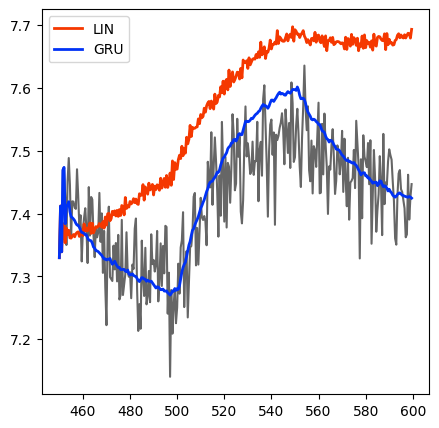

In [8]:
score_lin, LIN = get_offline_error_lin(900, 1200)
score_gru, GRU = get_offline_error_gru(900, 1200)

c1, c2, c3 = "#7AF500", "#F53800", "#0132F5"

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(LIN[:,0],LIN[:,1], c="k", alpha=.6)
ax.plot(LIN[:,0],LIN[:,2], c=c2, lw=2, label="LIN")
ax.plot(GRU[:,0],GRU[:,2], c=c3, lw=2, label="GRU")

ax.legend();

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/295 [00:00<?, ?it/s]

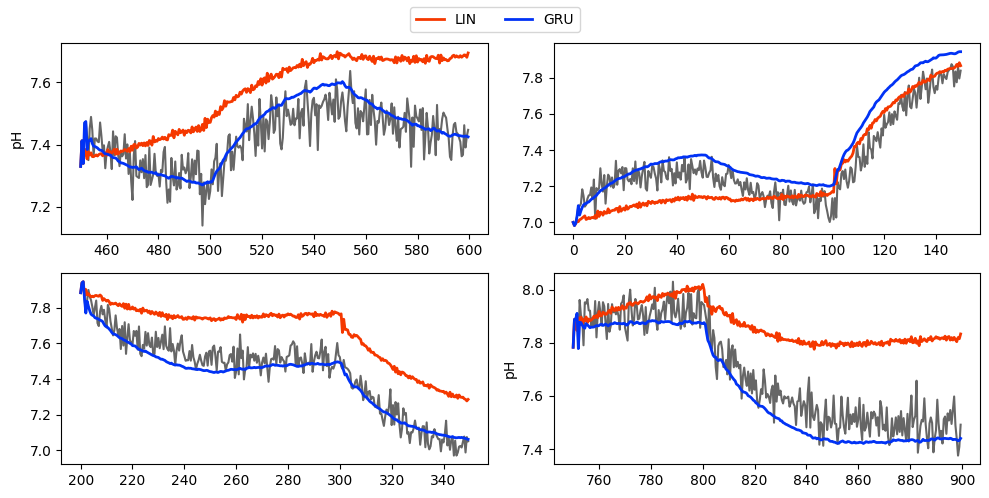

In [10]:
fig, ax = plt.subplots(2,2,figsize=(10, 5))
ax = ax.flatten()
dranges = [[900, 1200],
           [0, 300],
           [400, 700],
           [1500, 1800]]

for i in range(4):
    score_lin, LIN = get_offline_error_lin(dranges[i][0], dranges[i][1])
    score_gru, GRU = get_offline_error_gru(dranges[i][0], dranges[i][1])
    
    ax[i].plot(LIN[:,0],LIN[:,1], c="k", alpha=.6)
    ax[i].plot(LIN[:,0],LIN[:,2], c=c2, lw=2, label="LIN")
    ax[i].plot(GRU[:,0],GRU[:,2], c=c3, lw=2, label="GRU")

ax[0].set_ylabel("pH")
ax[3].set_ylabel("pH")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("results/offline_full.pdf", bbox_inches="tight")

In [11]:
def get_metrics(data):
    """
    Get the metrics beased on a dataset resulting from the
    simulations.

    Returns -> list(metrics)
    """

    Y_data = data[:, -1]
    U_data = data[:, :-1]

    IAE = np.sum(np.abs(ysp - Y_data) * dt)
    ITAE = np.sum(t_sim * np.abs(ysp - Y_data) * dt)
    EC = np.sum(np.abs(np.diff(U_data[:, 0])) * dt)

    return [IAE, ITAE, EC]

In [19]:
# SERVO
## loading data

ysp = np.loadtxt("results/ysp.csv", delimiter=",")

t_sim = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")[:, 0]
dt = t_sim[1] - t_sim[0]

PID_servo = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")[:, 1:]
LIN_servo = np.loadtxt("results/LIN/LIN_servo.csv", delimiter=",")[:, 1:]
GRU_servo = np.loadtxt("results/GRU/GRU_servo.csv", delimiter=",")[:, 1:]

PID_reg = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")[:, 1:]
LIN_reg = np.loadtxt("results/LIN/LIN_reg.csv", delimiter=",")[:, 1:]
GRU_reg = np.loadtxt("results/GRU/GRU_reg.csv", delimiter=",")[:, 1:]

servo_df = {
    "PID":get_metrics(PID_servo),
    "LIN":get_metrics(LIN_servo),
    "GRU":get_metrics(GRU_servo),
}

reg_df = {
    "PID":get_metrics(PID_reg),
    "LIN":get_metrics(LIN_reg),
    "GRU":get_metrics(GRU_reg),
}
index = ["IAE", "ITAE", "EC"]
servo_df = pd.DataFrame(servo_df, index=index).T
reg_df = pd.DataFrame(reg_df, index=index).T

servo_df_rel = servo_df.apply(lambda row: (row - servo_df.loc["PID"]) / servo_df.loc["PID"] * 100, axis=1)
reg_df_rel = reg_df.apply(lambda row: (row - reg_df.loc["PID"]) / reg_df.loc["PID"] * 100, axis=1)

servo_df_rel.columns =  [string + " (%)" for string in index]
reg_df_rel.columns =  [string + " (%)" for string in index]

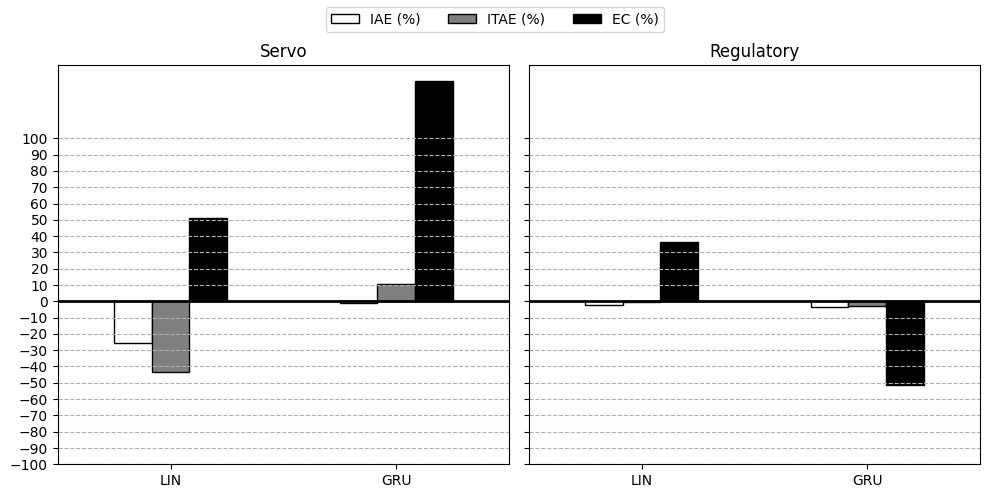

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
colors = ["white", "grey", "black"]

ax[0].set_title("Servo")
ax[0].axhline(0, c='k', lw=2)
servo_df_rel.loc[["LIN", "GRU"]].plot(kind="bar", ax=ax[0], edgecolor='black', color=colors)
ax[0].grid(axis='y', ls='--')
ax[0].legend_.remove()
ax[0].set_xticklabels(["LIN", "GRU"], rotation=0)

ax[1].set_title("Regulatory")
ax[1].axhline(0, c='k', lw=2)

reg_df_rel.loc[["LIN", "GRU"]].plot(kind="bar", ax=ax[1], edgecolor='black', color=colors)
ax[1].grid(axis='y', ls='--')
ax[1].legend_.remove()
ax[1].set_xticklabels(["LIN", "GRU"], rotation=0)
ax[1].set_yticks(np.arange(-100, 100+10, 10))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("results/metrics.pdf", bbox_inches="tight")

In [17]:
servo_df

,IAE,ITAE,EC
PID,40.981298,3578.535618,103.491559
LIN,32.169724,2142.150955,153.984196
GRU,39.805239,3701.983632,48.084994


In [18]:
reg_df

,IAE,ITAE,EC
PID,103.940871,7816.111555,81.931066
LIN,99.614833,7609.074089,90.606338
GRU,100.144574,7579.405351,39.786812
